In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from plaid.denoisers.modules import LabelEmbedder, SinusoidalTimestepEmbedder, FourierTimestepEmbedder

In [4]:
import torch
C = 64
t = torch.arange(0,1000).long()

In [7]:
sinusoidal = SinusoidalTimestepEmbedder(C)
sin_emb = sinusoidal.timestep_embedding(t, C)

In [8]:
fourier = FourierTimestepEmbedder(C)
fourier_emb = fourier.timestep_embedding(t, C)

Text(50.722222222222214, 0.5, 'Channel Dimension')

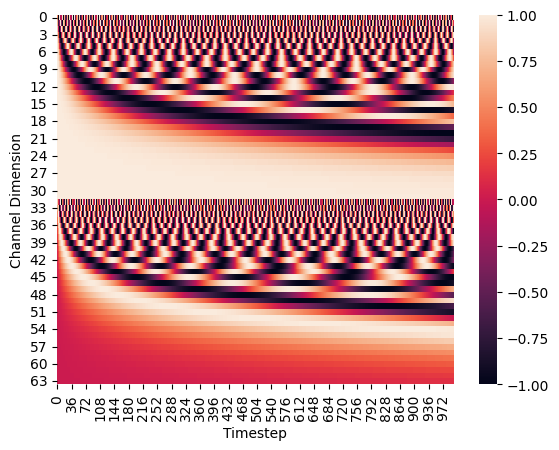

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(sin_emb.T)
plt.xlabel("Timestep")
plt.ylabel("Channel Dimension")

<Axes: >

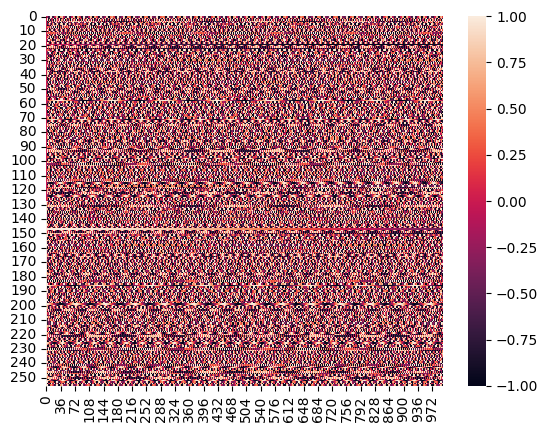

In [10]:
sns.heatmap(fourier_emb.T)

In [13]:
from plaid.denoisers.modules import get_1d_sincos_pos_embed

pos = torch.arange(512)
pos_emb = get_1d_sincos_pos_embed(C, pos)

Text(50.722222222222214, 0.5, 'Channel dimension')

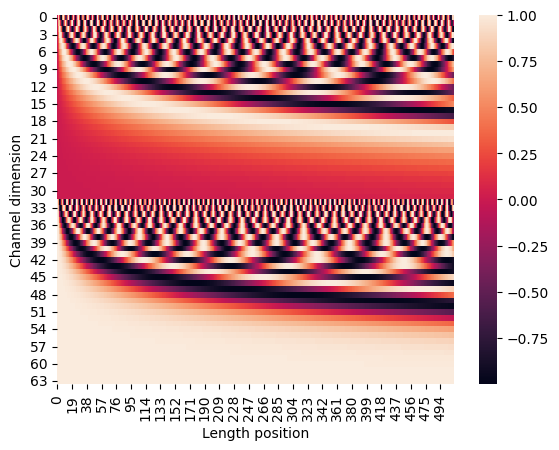

In [14]:
sns.heatmap(pos_emb.T)
plt.xlabel("Length position")
plt.ylabel("Channel dimension")

In [15]:
from plaid.denoisers.modules._embedders import SinusoidalPosEmb, LearnedSinusoidalPosEmb

In [19]:
x = torch.ones((4, 1000, 128))

In [23]:
# spe = SinusoidalPosEmb(dim=128)
lspe = LearnedSinusoidalPosEmb(dim=128)

In [25]:
lspe(x)

EinopsError:  Error while processing rearrange-reduction pattern "b -> b 1".
 Input tensor shape: torch.Size([4, 1000, 128]). Additional info: {}.
 Wrong shape: expected 1 dims. Received 3-dim tensor.

In [31]:
from torch import nn
import math


class SinePositionalEmbedding(nn.Module):
    def __init__(self, dim_model: int, *args, **kwargs):
        super().__init__()
        self.dim_model = dim_model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        seq_len = x.shape[1]
        pos = (
            torch.arange(0, seq_len, device=x.device, dtype=torch.float32)
            .unsqueeze(1)
            .repeat(1, self.dim_model)
        )
        dim = (
            torch.arange(0, self.dim_model, device=x.device, dtype=torch.float32)
            .unsqueeze(0)
            .repeat(seq_len, 1)
        )
        div = torch.exp(-math.log(10000) * (2 * (dim // 2) / self.dim_model))
        pos *= div
        pos[:, 0::2] = torch.sin(pos[:, 0::2])
        pos[:, 1::2] = torch.cos(pos[:, 1::2])

        output = x.unsqueeze(-1) if x.ndim == 2 else x

        return output + pos.unsqueeze(0)

In [32]:
pe = SinePositionalEmbedding(512)

In [41]:
x = torch.ones((1, 1000, 512))

In [42]:
pe_emb = pe(x)

In [43]:
pe_emb.shape

torch.Size([1, 1000, 512])

Text(50.722222222222214, 0.5, 'Channel')

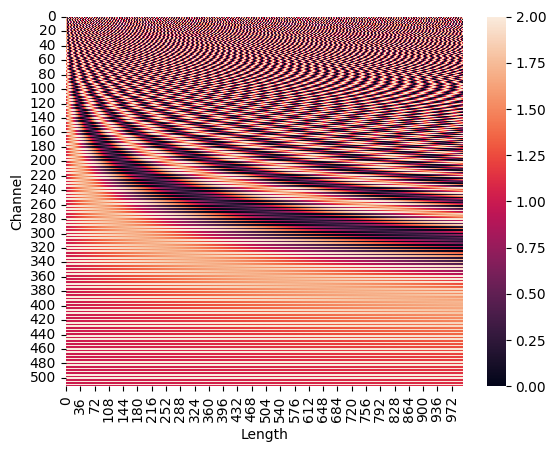

In [45]:
sns.heatmap(pe_emb.squeeze().T)
plt.xlabel("Length")
plt.ylabel("Channel")